# importing packages

In [43]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display

In [2]:
# import some helpful python packages 
import numpy as np

from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

%matplotlib inline

In [3]:
# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask
from desitarget import __version__ as desitarget_version
from desitarget.targetmask import desi_mask

## DataLab related modules
from sparcl.client import SparclClient

### Alot of the functionality of datalab is locked behind an authentication

In [4]:
from dl import queryClient as qc, authClient as ac

In [5]:
ac.login(input("Enter user name: (+ENTER) "), input("Enter password: (+ENTER) ")) # credentials to log into datalab


Enter user name: (+ENTER)  edm2158
Enter password: (+ENTER)  Poohbaby123!


'edm2158.4258.4258.$1$0s4qYkVC$kJcE3yIQYSdewtBL0p0xn.'

In [6]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

In [7]:
## Load SPARCLClient
client = SparclClient()

In [8]:
print(qc.schema('desi_edr'))


Schema: desi_edr

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_edr.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_edr

In [9]:
## Columns in the zpix table
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber_dec   Mean (over exposures) DEC of actual fiber position
            elon   Ecliptic longitude
            elat   Ecliptic latitude


# Query what we need from desi edr

In [10]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
""" 

## Information about the query
## Selected columns --
## targetid, survey, program -- unique identifiers for a given spectrum
## healpix -- healpix number for the target
## z -- spectroscopic redshift of the target
## zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
## coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
## spectype -- Spectral type of the target: STAR | GALAXY | QSO
## mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
## zcat_nspec -- Number of coadded spectra that are available for a given target
## zcat_primary -- Whether or not a given coadded spectra is the primary spectra. ZCAT_PRIMARY = True for the "best" spectrum.
## CASTing this column as an INT: ZCAT_PRIMARY = 1 for the "best" spectrum.
## desi_target -- encodeds main survey's desi targeting information - explained in detail below
## sv1_desi_target -- encodes sv1 desi targeting information
## sv2_desi_target -- encodes sv2 desi targeting information
## sv3_desi_target -- encodes sv3 desi targeting information

In [11]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp



In [12]:
%%time
zpix = qc.query(sql = query, fmt = 'pandas')

CPU times: user 3.57 s, sys: 2.5 s, total: 6.07 s
Wall time: 1min 42s


In [13]:
print(f"The resulting table has {len(zpix)} rows")
zpix[0:5]

The resulting table has 2044588 rows


,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
0,39633405607936686,sv3,dark,15340,0.349208,0,0,QSO,272.41810,61.551533,2,1,0,0,0,1152921504606855433
1,39633405607936686,sv3,bright,15340,0.349182,0,0,QSO,272.41812,61.551567,2,0,0,0,0,1152921504606855433
2,39633405607936462,sv3,bright,15340,-0.000327,0,0,STAR,272.39273,61.551990,1,1,0,0,0,2305843009213693952
3,39633405607936221,sv3,bright,15340,-0.000064,0,0,STAR,272.36700,61.496170,1,1,0,0,0,2305843009213693952
4,39633405603746754,sv3,bright,15340,0.262433,0,0,GALAXY,272.34732,61.499382,1,1,0,0,0,1152921504606846976


In [14]:
# Check how many rows have unique TARGETIDs before/after applying the ZCAT_PRIMARY flag
print(f"Total N(rows) : {len(zpix)}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix['targetid']))}")

is_primary = zpix['zcat_primary']==1

print(f"N(rows) with ZCAT_PRIMARY=True : {len(zpix[is_primary])}")

Total N(rows) : 2044588
N(rows) with unique TARGETIDs : 1979269
N(rows) with ZCAT_PRIMARY=True : 1979269


In [15]:
## Selecting only unique objects
zpix_cat = zpix[is_primary]

In [16]:
# Targeting bits are coded in the sv*_targetmask.desi_mask
sv1_targetmask.desi_mask

sv1_desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [LRG_OPT,          3, "LRG from baseline version of optical cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 4}]
  - [LRG_IR,           4, "LRG from baseline version of IR cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MO

In [17]:
# A few example bitmask values

print(sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

34359738368 34359738368 42949672960
8589934592 34359738368 42949672960


In [18]:
# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = zpix_cat['sv1_desi_target']
sv2_desi_tgt = zpix_cat['sv2_desi_target']
sv3_desi_tgt = zpix_cat['sv3_desi_target']

## DESI Bitmasks
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

In [19]:
# Selecting candidates - 

is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

In [20]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

## Distribution of objects in desi edr

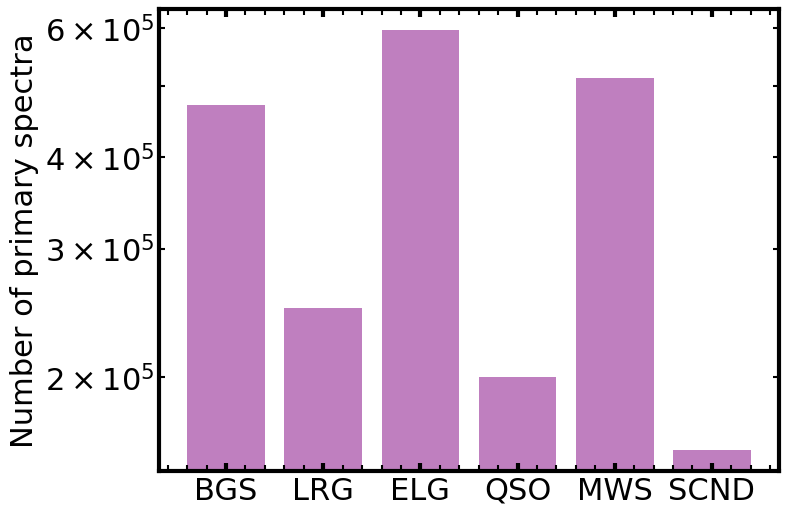

In [21]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8,6))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

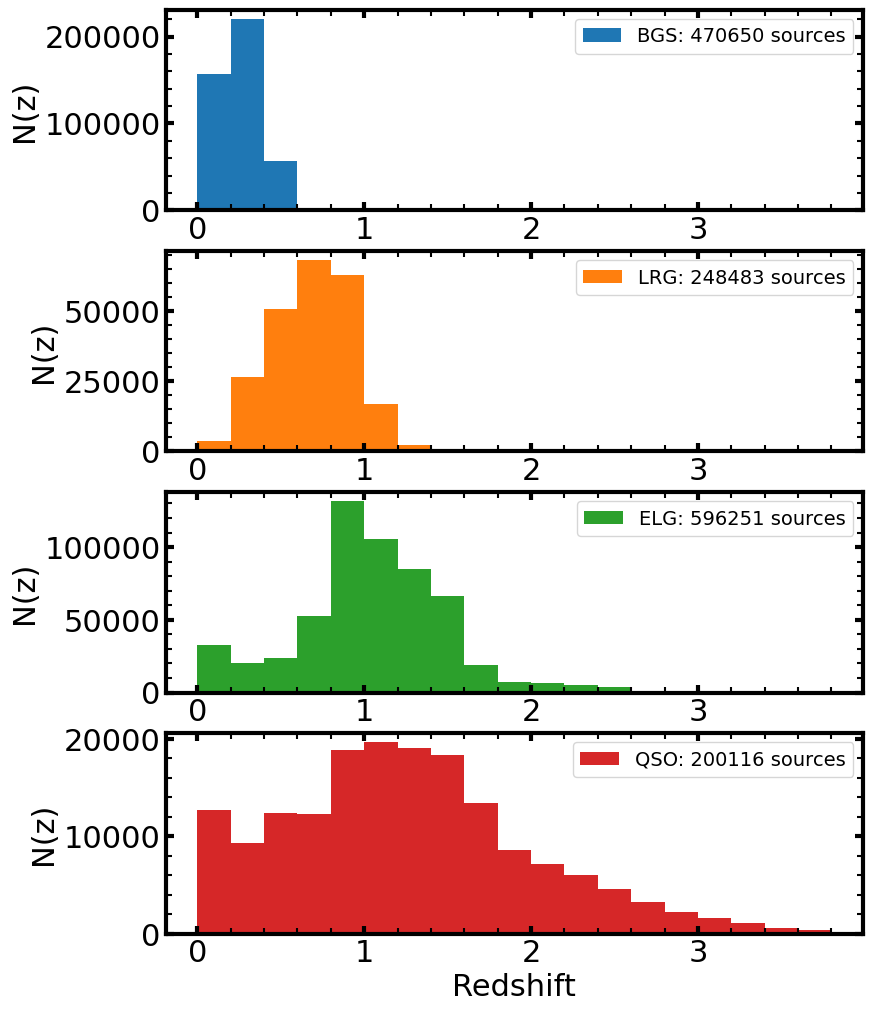

In [22]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zpix_cat['z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zpix_cat['z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zpix_cat['z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zpix_cat['z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")

In [23]:
hpx = 26279      

sel = (zpix_cat['healpix'] == hpx)
tsel = zpix_cat[sel]

In [24]:
## Selecting MWS sources in this regions
is_mws = (tsel['sv1_desi_target'] & sv1_targetmask.desi_mask['MWS_ANY'] != 0)|(tsel['sv2_desi_target'] & sv2_targetmask.desi_mask['MWS_ANY'] != 0)|(tsel['sv3_desi_target'] & sv3_targetmask.desi_mask['MWS_ANY'] != 0)

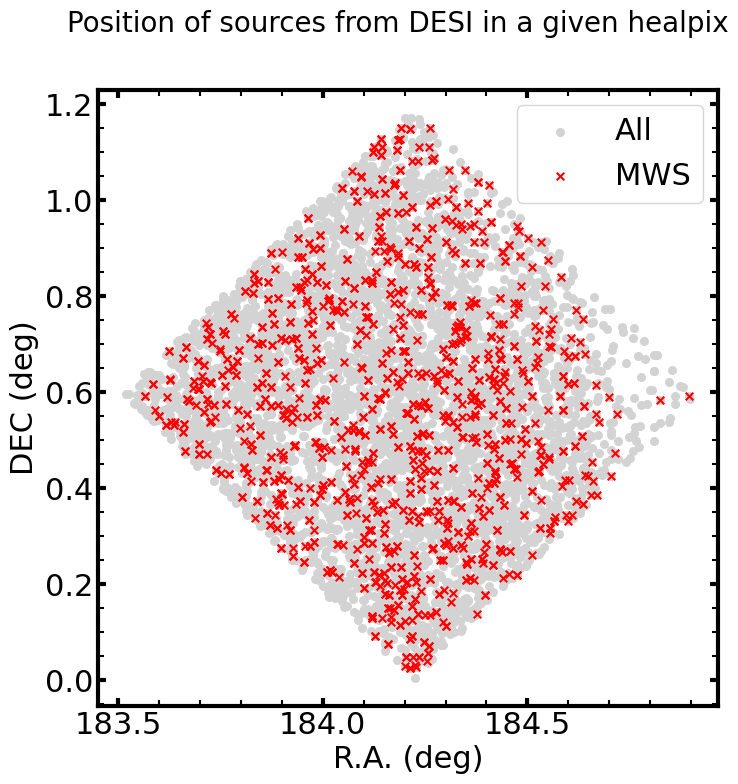

In [25]:
plt.figure(figsize = (8, 8))

plt.suptitle('Position of sources from DESI in a given healpix', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'lightgrey', s = 30, label = 'All')
plt.scatter(tsel['mean_fiber_ra'][is_mws], tsel['mean_fiber_dec'][is_mws], color = 'r', s = 30, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting the Spectra of a Given Object

Shows how to access all the available healpix-coadded spectra of a given object. <br/>
Use SPARCL, which is a fast spectral access service at Data Lab. <br/>
Detailed ways to using SPARCL are available in this [notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

## First we have to see if all of these objects are ELGs

In [26]:
elg = zpix_cat[is_elg]

Text(0.5, 0, 'Redshift')

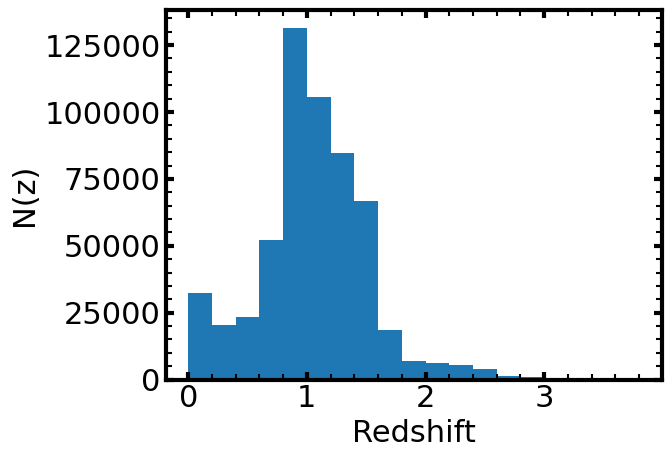

In [27]:
plt.hist(elg['z'], bins = bins)
plt.ylabel('N(z)')
plt.xlabel('Redshift')

In [28]:
np.sum(elg['spectype'] == 'QSO')

40440

In [29]:
mask = elg['spectype'].values == 'QSO'

In [30]:
new_array_QSO =elg.loc[mask]


In [31]:
new_array_QSO

# 40000 rows within the ELG query are marked as QSOs

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
31,39633405607936822,sv3,dark,15340,2.728881,0,0,QSO,272.42963,61.595060,1,1,0,0,0,4674
75,39633405603745182,sv3,dark,15342,1.889995,0,0,QSO,272.17538,61.497746,1,1,0,0,0,5702
147,39633408485232706,sv3,dark,15342,1.722571,0,0,QSO,272.24265,61.639970,1,1,0,0,0,4611686018427393606
170,39633405603744530,sv3,dark,15342,2.118182,0,0,QSO,272.10895,61.571200,1,1,0,0,0,4611686018427393606
196,39633408485231664,sv3,dark,15342,1.141079,0,0,QSO,272.14100,61.655495,1,1,0,0,0,4611686018427393606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044427,39633405607936845,sv3,dark,15340,2.216448,0,0,QSO,272.43110,61.406760,1,1,0,0,0,4611686018427393606
2044429,39633405607936238,sv3,dark,15340,2.740281,0,0,QSO,272.36914,61.394280,1,1,0,0,0,4611686018427393606
2044451,39633405603746303,sv3,dark,15342,1.537800,0,0,QSO,272.29376,61.424680,1,1,0,0,0,5702
2044526,39633405603745099,sv3,dark,15342,1.733955,0,0,QSO,272.16684,61.422802,1,1,0,0,0,4611686018427393606


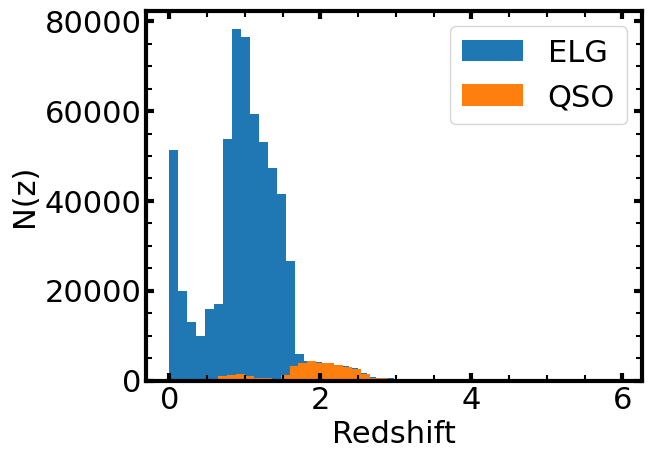

In [32]:
# plots distribution of ELGs and QSOs by redshift 
plt.hist(elg['z'], bins = 50, label = "ELG")
plt.hist(new_array_QSO['z'], bins = 50, label = "QSO")
plt.ylabel('N(z)')
plt.xlabel('Redshift')
plt.legend()

The orange indicates that the tail end of the distribution <br/>
of ELGs are marked as QSO's by the Redrock template <br/>


In [33]:
# created a mask to only show the galaxies within the ELG query. Which removes the QSO that are marked

mask2 = elg['spectype'].values == 'GALAXY'
new_elg_sample = elg.loc[mask2]
new_elg_sample

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
6,39633405603746559,sv3,dark,15342,0.961473,0,0,GALAXY,272.32507,61.504490,1,1,0,0,0,4674
14,39633405603746334,sv3,dark,15342,0.951931,0,0,GALAXY,272.29752,61.524826,1,1,0,0,0,4674
18,39633405603746175,sv3,dark,15342,1.517600,0,0,GALAXY,272.27840,61.529926,1,1,0,0,0,4674
20,39633405603746163,sv3,dark,15342,0.921096,0,0,GALAXY,272.27725,61.533394,1,1,0,0,0,4674
21,39633405603746462,sv3,dark,15342,0.955582,0,0,GALAXY,272.31247,61.544907,1,1,0,0,0,4674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044574,39633405603744208,sv3,dark,15342,0.866510,0,0,GALAXY,272.07297,61.479330,1,1,0,0,0,4674
2044580,39633405607936603,sv3,dark,15340,1.203081,0,0,GALAXY,272.40820,61.479816,1,1,0,0,0,4674
2044581,39633405607936395,sv3,dark,15340,0.866633,0,0,GALAXY,272.38680,61.505800,1,1,0,0,0,5702
2044585,39633405607936929,sv3,dark,15340,1.080380,0,0,GALAXY,272.43887,61.552807,1,1,0,0,0,4674


Text(0.5, 0, 'Redshift')

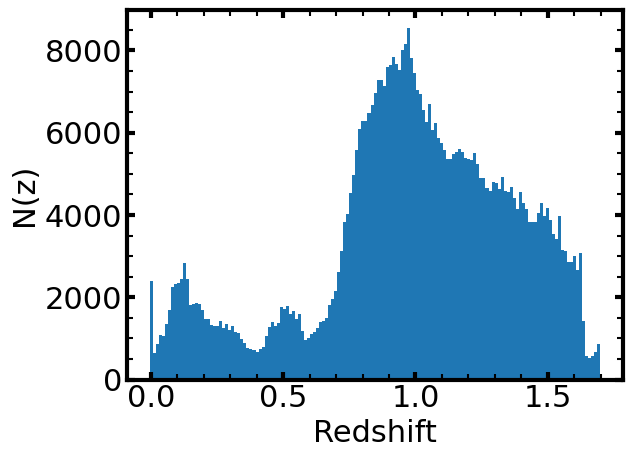

In [34]:
# distribution of ELG Sample after the filtering

plt.hist(new_elg_sample['z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

## Doing the same to the QSO as well

In [35]:
## Select QSO with nspec > 3 (nspec is just the number of available spectra)

jj = (zpix_cat['zcat_nspec'] >= 1)&(zpix_cat['spectype'] == 'QSO')
QSO_spec = zpix_cat[jj]

In [36]:
# Just plotting the table

QSO_spec

,targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
0,39633405607936686,sv3,dark,15340,0.349208,0,0,QSO,272.41810,61.551533,2,1,0,0,0,1152921504606855433
31,39633405607936822,sv3,dark,15340,2.728881,0,0,QSO,272.42963,61.595060,1,1,0,0,0,4674
45,39633408489423167,sv3,bright,15340,0.347282,0,0,QSO,272.38876,61.636013,1,1,0,0,0,1152921504606846976
70,39633405603745713,sv3,dark,15342,1.715298,0,0,QSO,272.23080,61.482063,1,1,0,0,0,1028
75,39633405603745182,sv3,dark,15342,1.889995,0,0,QSO,272.17538,61.497746,1,1,0,0,0,5702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044451,39633405603746303,sv3,dark,15342,1.537800,0,0,QSO,272.29376,61.424680,1,1,0,0,0,5702
2044505,39633405603744698,sv3,dark,15342,1.989650,0,0,QSO,272.12753,61.378660,1,1,0,0,0,1028
2044526,39633405603745099,sv3,dark,15342,1.733955,0,0,QSO,272.16684,61.422802,1,1,0,0,0,4611686018427393606
2044558,39633405603744197,sv3,dark,15342,2.606296,0,0,QSO,272.07140,61.413498,1,1,0,0,0,1028


Text(0.5, 0, 'Redshift')

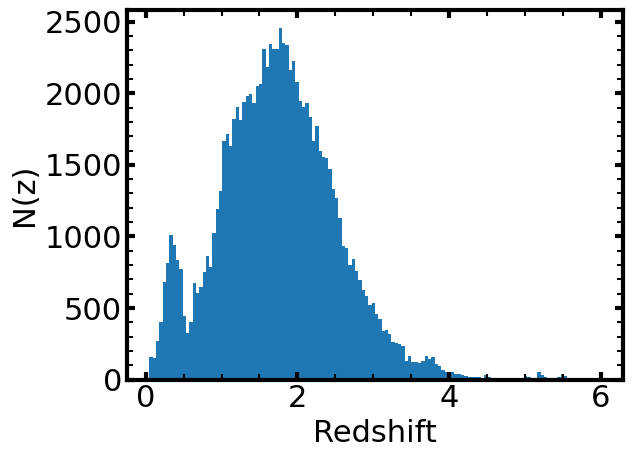

In [37]:
# Plot the distribution of the elg sample

plt.hist(QSO_spec['z'], bins = 'auto')
plt.ylabel('N(z)')
plt.xlabel('Redshift')

## Visualizing where our sample is

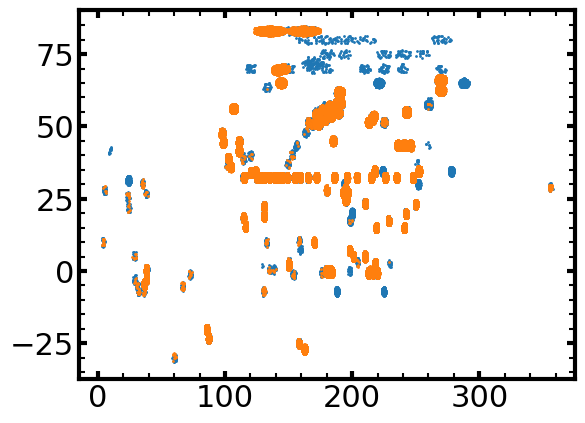

In [38]:
ra_QSO = QSO_spec['mean_fiber_ra']
dec_QSO = QSO_spec['mean_fiber_dec']

ra_elg = new_elg_sample['mean_fiber_ra']
dec_elg = new_elg_sample['mean_fiber_dec']

plt.scatter(ra_QSO, dec_QSO, s = 1)
plt.scatter(ra_elg, dec_elg, s = 1)


In [39]:

is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)

In [40]:
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)

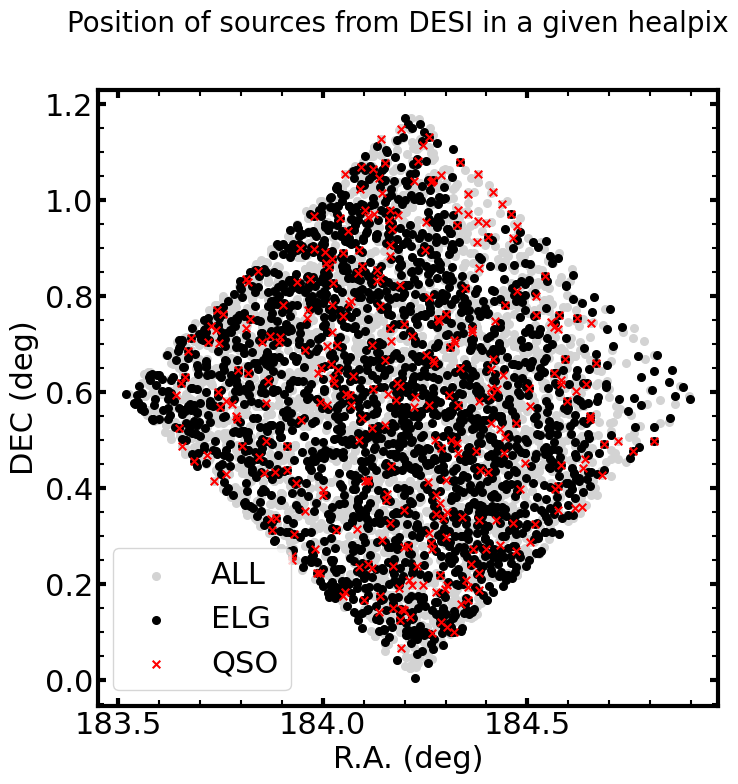

In [41]:
plt.figure(figsize = (8, 8))

plt.suptitle('Position of sources from DESI in a given healpix', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'lightgrey', s = 30, label = 'ALL')
plt.scatter(tsel['mean_fiber_ra'][is_elg], tsel['mean_fiber_dec'][is_elg], color = 'black', s = 30, label = 'ELG')
plt.scatter(tsel['mean_fiber_ra'][is_qso], tsel['mean_fiber_dec'][is_qso], color = 'r', s = 30, marker = 'x', label = 'QSO')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

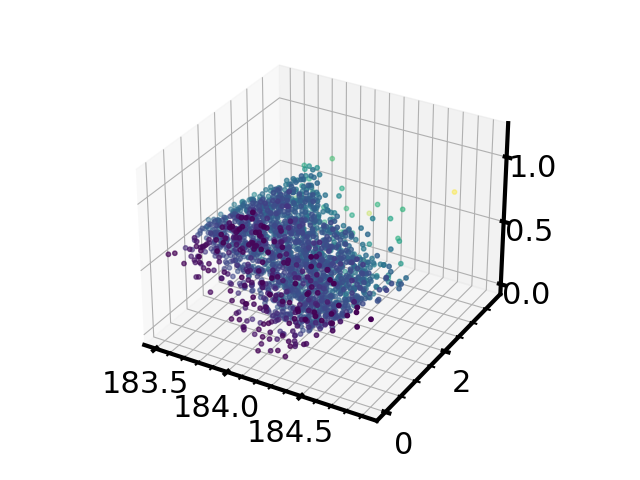

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.rcParams["figure.autolayout"] = True

#ax.scatter(tsel['mean_fiber_ra'], tsel['z'], tsel['mean_fiber_dec'], color = 'gray', s = 1)
ax.scatter(tsel['mean_fiber_ra'][is_elg], tsel['z'][is_elg], tsel['mean_fiber_dec'][is_elg], c = tsel['z'][is_elg], s = 10, label = 'ELG')
#ax.scatter(tsel['mean_fiber_ra'][is_qso], tsel['z'][is_qso], tsel['mean_fiber_dec'][is_qso], c = tsel['z'][is_qso], s = 1, marker = 'x', label = 'QSO')



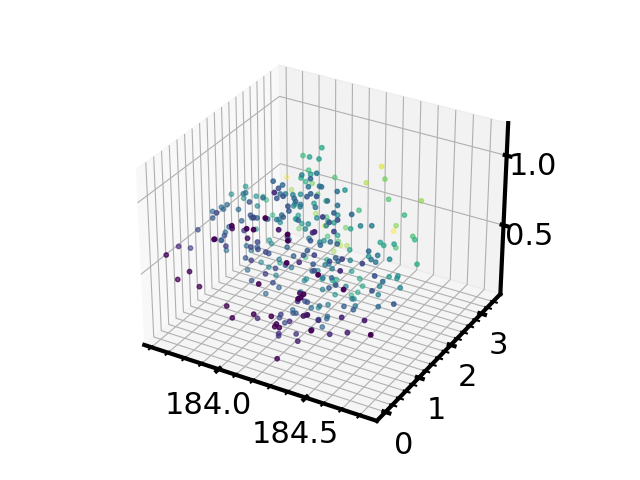

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.rcParams["figure.autolayout"] = True

#ax.scatter(tsel['mean_fiber_ra'], tsel['z'], tsel['mean_fiber_dec'], color = 'gray', s = 1)
ax.scatter(tsel['mean_fiber_ra'][is_qso], tsel['z'][is_qso], tsel['mean_fiber_dec'][is_qso], c = tsel['z'][is_qso], s = 10, label = 'ELG')

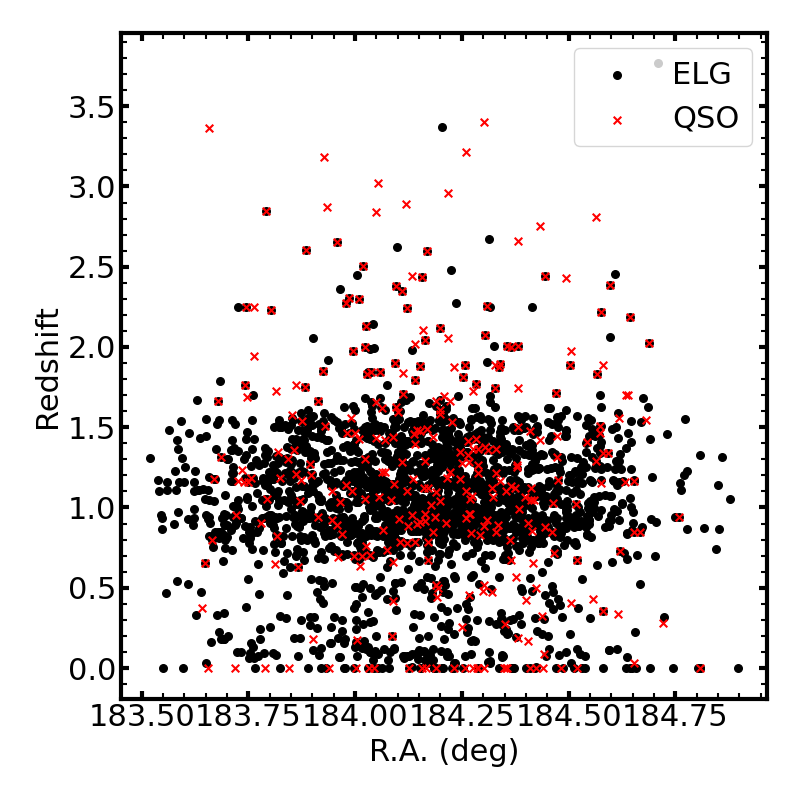

In [65]:
plt.figure(figsize = (8, 8))

plt.scatter(tsel['mean_fiber_ra'][is_elg], tsel['z'][is_elg], color = 'black', s = 30, label = 'ELG')
plt.scatter(tsel['mean_fiber_ra'][is_qso], tsel['z'][is_qso], color = 'r', s = 30, marker = 'x', label = 'QSO')
plt.xlabel('R.A. (deg)')
plt.ylabel('Redshift')
plt.legend()

## Plotting SPectra


Now lets look st the QSO's we filtered out of the ELG sample to see if they are actually QSOs

In [208]:
## Randomly select an object from the QSO's that are filtered from the sample

ii = 0
targetid = int(QSO_spec['targetid'].iloc[ii])   ## SPARCL accepts only python integers

In [209]:
## name of qso object

targetid

39633405607936686

In [210]:
## Retrieve Spectra

inc = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
res = client.retrieve_by_specid(specid_list = [targetid],
                                include = inc,
                                dataset_list = ['DESI-EDR'])

In [211]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].iloc[ii])
print ('Number of retrieved records: ', len(res.records))


Number of coadded spectra:  1
Number of retrieved records:  2


In [212]:
records = res.records

## Select the primary spectrum
spec_primary = np.array([records[jj].specprimary for jj in range(len(records))])

primary_ii = np.where(spec_primary == True)[0][0]

In [213]:
lam_primary = records[primary_ii].wavelength
flam_primary = records[primary_ii].flux
redshift = records[primary_ii].redshift

In [214]:
redshift

0.349207556253762

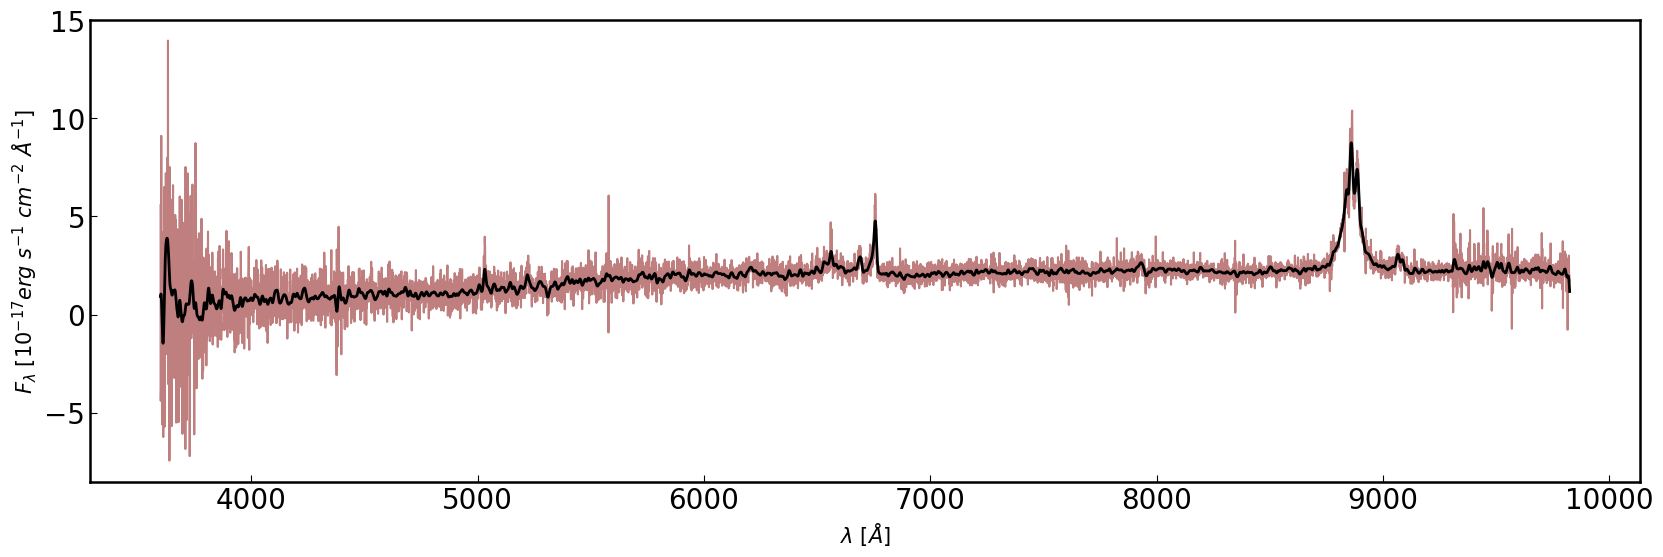

In [215]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(lam_primary, flam_primary, color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectra in black 
plt.plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

You can check whether some of these objects are QSO 
by using [this link](https://www.legacysurvey.org/viewer/desi-spectrum/edr/targetid39633405607936686).

Quick NOte: If you're looking for a specfic targetid simply use the link abover and remove <br/>
the string of numbers after targetid and replace it with the targetid that you want to view. IN this case, <br/>
the target that we waant to view is 39633405607936686

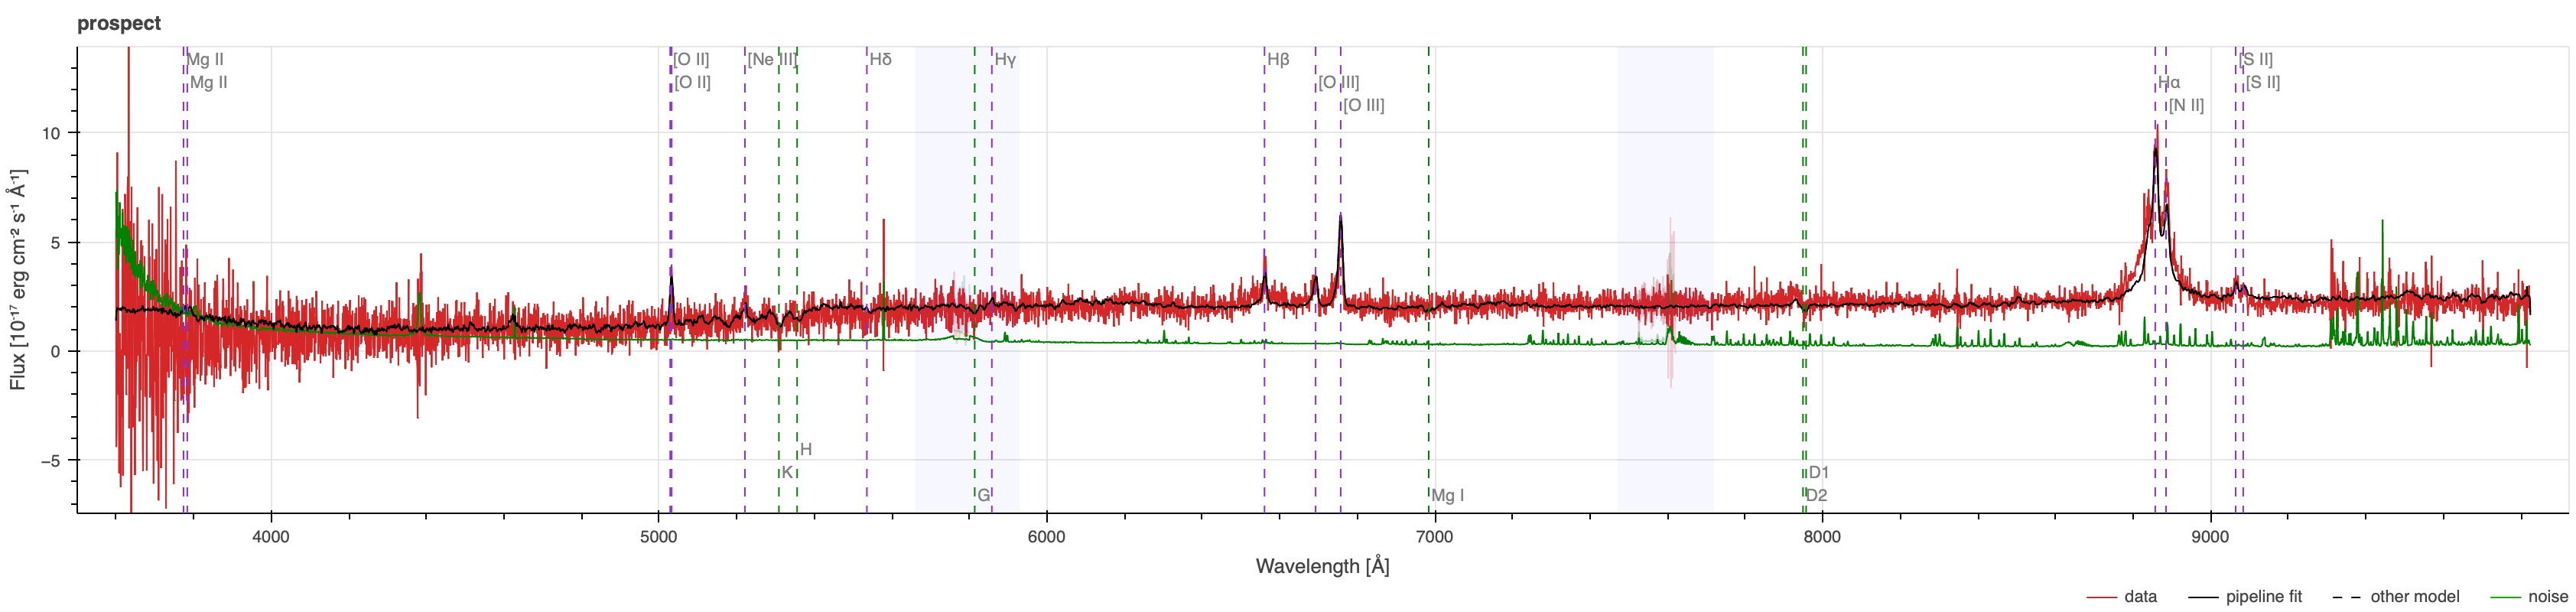

Picture from the DESI LEgacy spectral viewer

### Plotting the IVAR as well

In [239]:
#calculates noise from IVAR

ivar_primary = records[primary_ii].ivar
err = 1/np.sqrt(ivar_primary)

Text(0.5, 0, 'Wavelength (Å)')

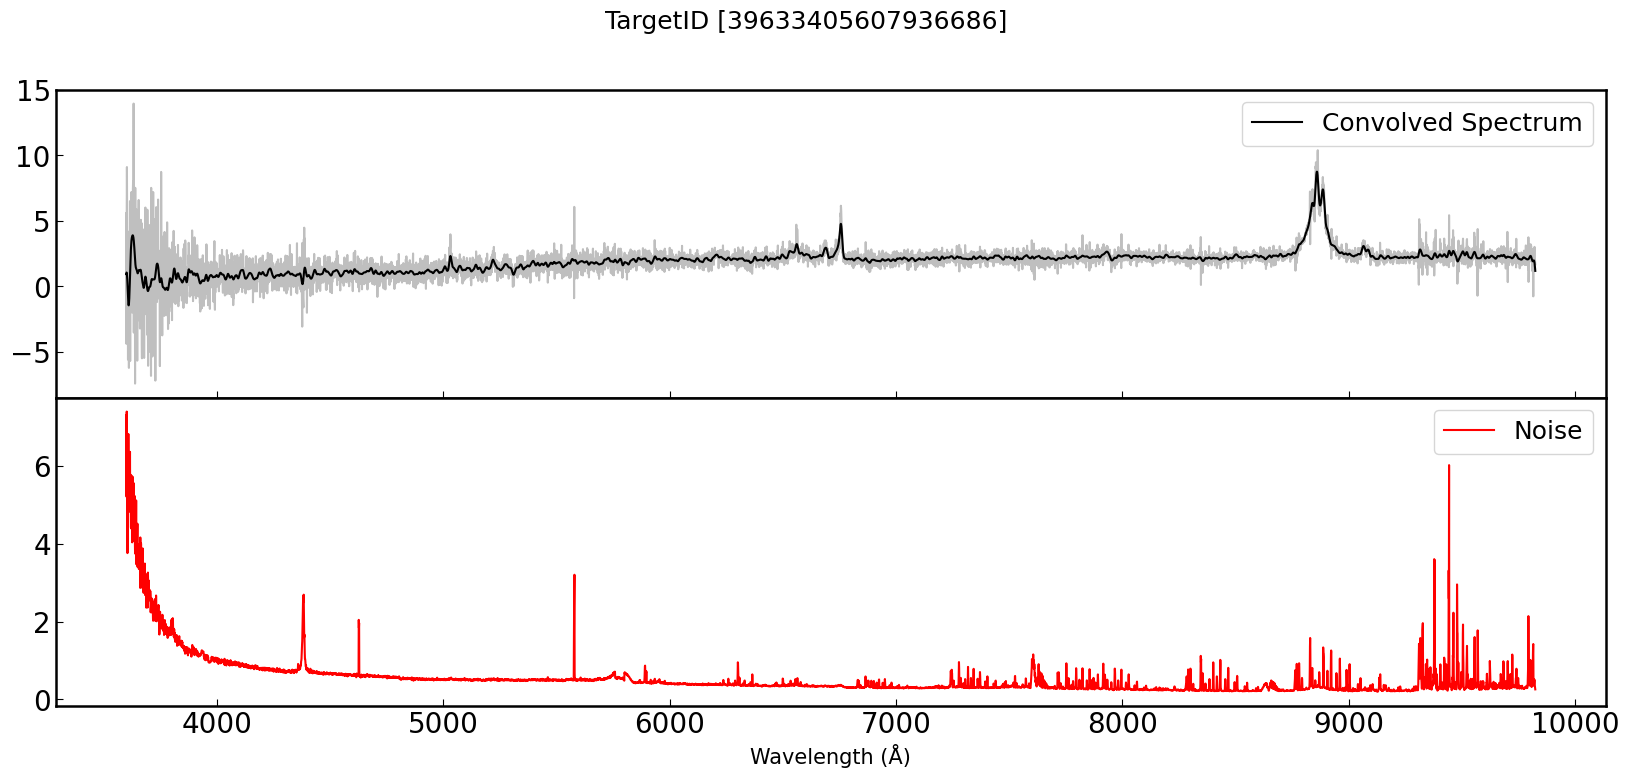

In [240]:
# subplot for QSO and IVAR

fig = plt.figure(figsize = (20,8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('TargetID [39633405607936686]')
axs[0].plot(lam_primary, flam_primary, color = 'gray', alpha = 0.5) 
axs[0].plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', label = 'Convolved Spectrum')
axs[0].legend()

axs[1].plot(lam_primary, err, color = 'red', label = 'Noise')
axs[1].legend(loc='upper right')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


plt.xlabel('Wavelength (Å)')

### Plotting ELG Spectra

Doing the same as the cells in the previous section

In [218]:
## Randomly select an object from the QSO's that are filtered from the sample

jj = 1
targetid_elg = int(new_elg_sample['targetid'].iloc[jj])   ## SPARCL accepts only python integers

In [219]:
targetid_elg

39633405603746334

In [220]:
## Retrieve Spectra

inc_elg = ['specid', 'redshift', 'flux', 'ivar', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
res_elg = client.retrieve_by_specid(specid_list = [targetid_elg],
                                include = inc_elg,
                                dataset_list = ['DESI-EDR'])

In [221]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].iloc[jj])
print ('Number of retrieved records: ', len(res_elg.records))

Number of coadded spectra:  1
Number of retrieved records:  1


In [222]:
records_elg = res_elg.records

## Select the primary spectrum
spec_primary_elg = np.array([records_elg[j].specprimary for j in range(len(records_elg))])

primary_ii_elg = np.where(spec_primary_elg == True)[0][0]

In [223]:
lam_primary_elg = records_elg[primary_ii_elg].wavelength
flam_primary_elg = records_elg[primary_ii_elg].flux
redshift_elg = records_elg[primary_ii_elg].redshift

In [224]:
redshift_elg

0.951931386769244

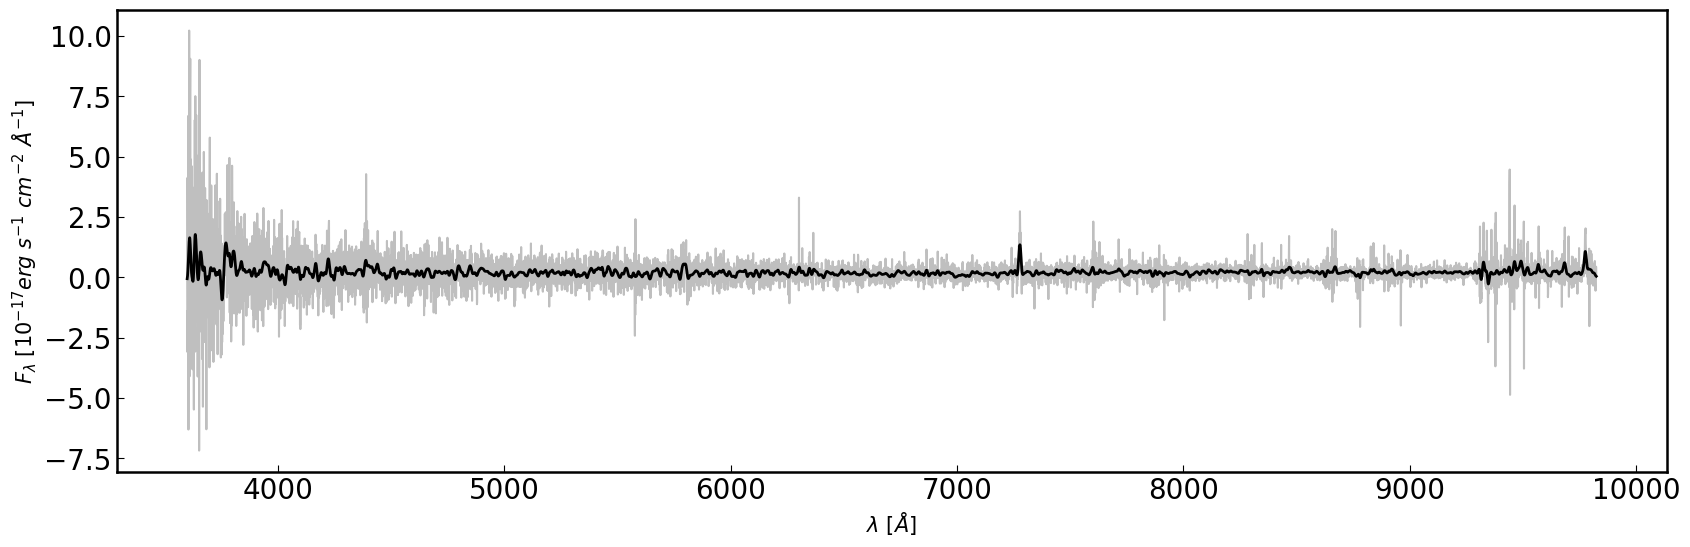

In [225]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(lam_primary_elg, flam_primary_elg, color = 'gray', alpha = 0.5)
# Over-plotting smoothed spectra in black 
plt.plot(lam_primary_elg, convolve(flam_primary_elg, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

In [226]:
# Plotting ivar again

ivar_primary_elg = records_elg[primary_ii_elg].ivar
err_elg = 1/np.sqrt(ivar_primary_elg)

Text(0.5, 0, 'Wavelength (Å)')

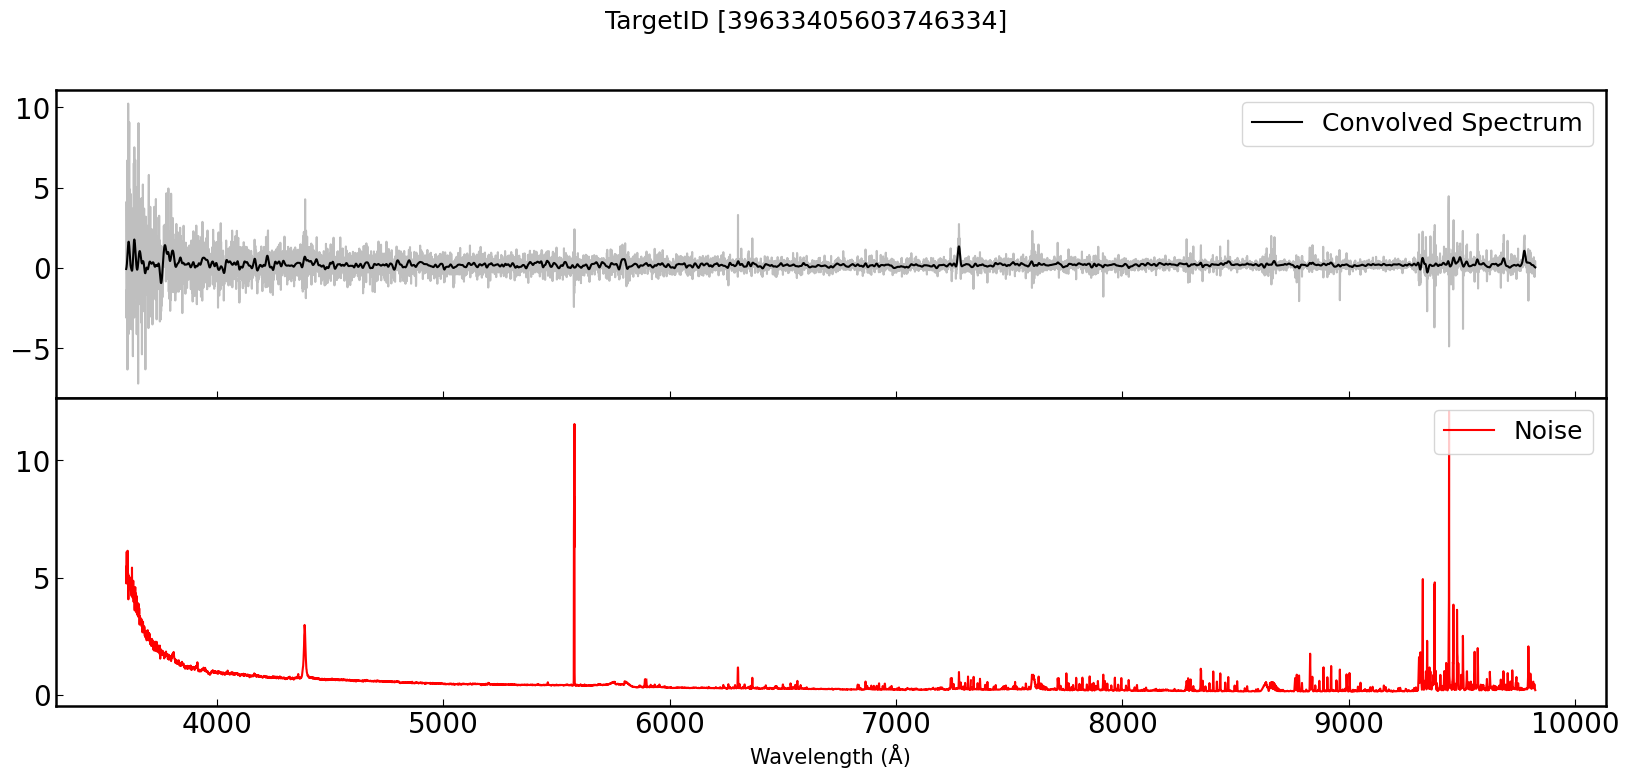

In [227]:
# subplot for QSO and IVAR

fig = plt.figure(figsize = (20,8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('TargetID [39633405603746334]')
axs[0].plot(lam_primary_elg, flam_primary_elg, color = 'gray', alpha = 0.5) 
axs[0].plot(lam_primary_elg, convolve(flam_primary_elg, Gaussian1DKernel(5)), color = 'k', label = 'Convolved Spectrum')
axs[0].legend()

axs[1].plot(lam_primary_elg, err_elg, color = 'red', label = 'Noise')
axs[1].legend(loc='upper right')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


plt.xlabel('Wavelength (Å)')

# Adding the spectra as a proxy for the rest of the training set

Similar to J0919 we will look at a lensed spectra, however, because only a few are confirmed the <br/>
best course of action is to simulate the spectra of a lensed ELG by adding the spectra together instead of subtracting them.

The Below is an example of only 1 elg and how this can be used to create more in our training sample.

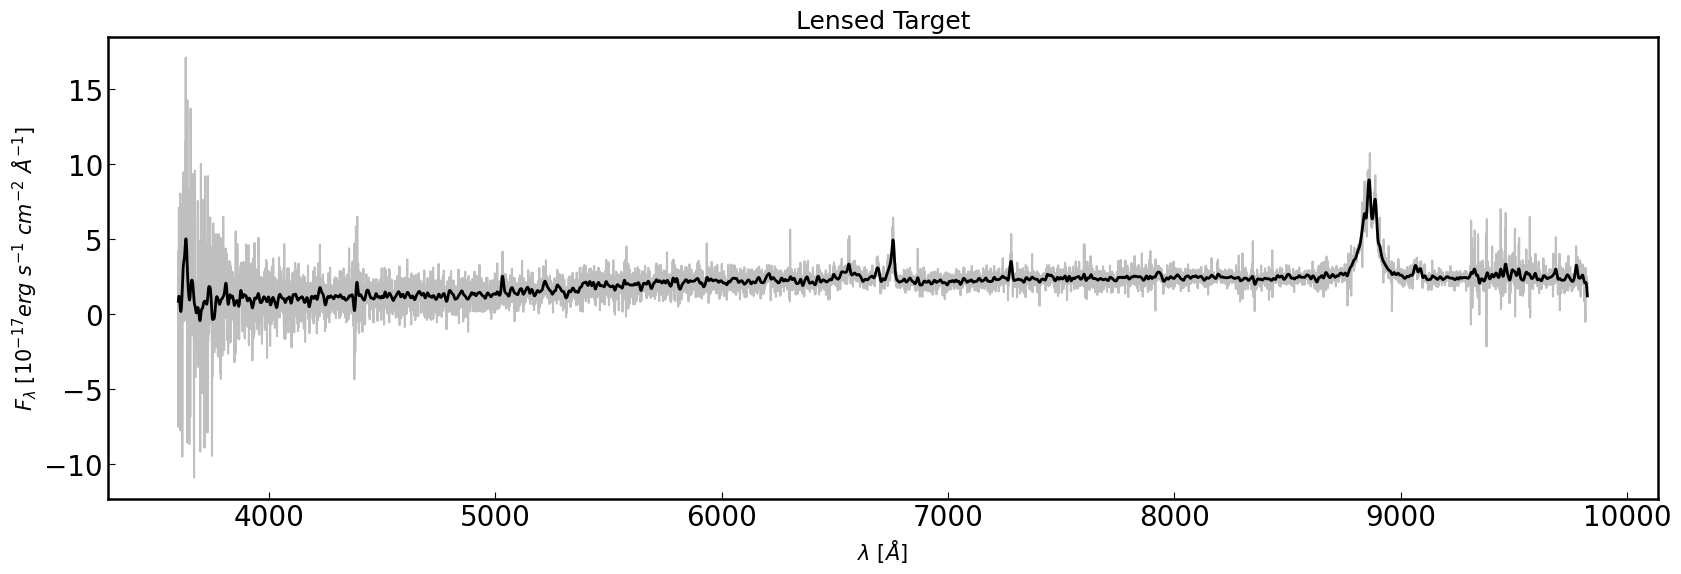

In [228]:
plt.figure(figsize = (20, 6))

Added_flux = flam_primary_elg + flam_primary

plt.plot(lam_primary_elg, Added_flux, color = 'gray', alpha = 0.5)
# Over-plotting smoothed spectra in black 
plt.plot(lam_primary_elg, convolve(Added_flux, Gaussian1DKernel(5)), color = 'k', lw = 2.0)

plt.title('Lensed Target')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.savefig('Lense_example')
plt.show()

## Lets see how the other plots compare to this one

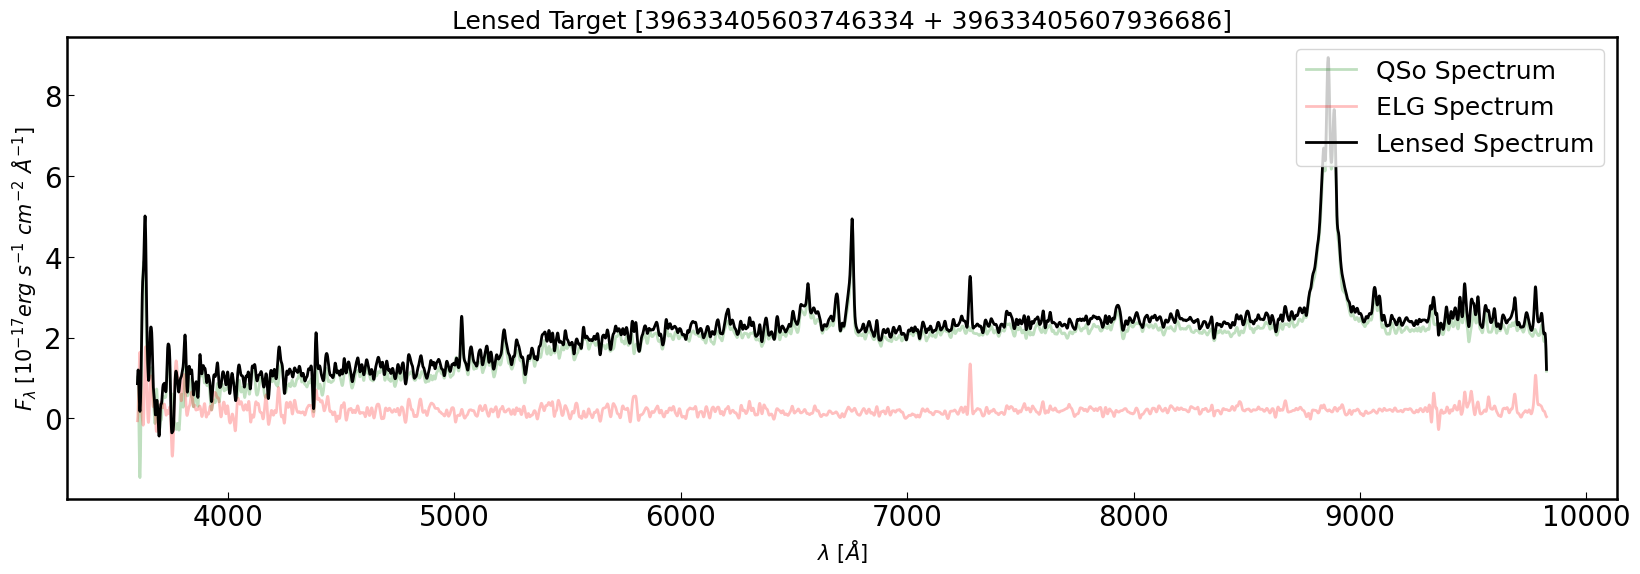

In [241]:
plt.figure(figsize = (20, 6))

Added_flux = flam_primary_elg + flam_primary

plt.plot(lam_primary_elg, convolve(flam_primary, Gaussian1DKernel(5)), color = 'green', linestyle = 'solid', lw = 2.0, alpha = .25, label = 'QSo Spectrum')
plt.plot(lam_primary_elg, convolve(flam_primary_elg, Gaussian1DKernel(5)), color = 'red', linestyle = 'solid', lw = 2.0, alpha = .25, label = 'ELG Spectrum')
# Over-plotting smoothed spectra in black 
plt.plot(lam_primary_elg, convolve(Added_flux, Gaussian1DKernel(5)), color = 'k', lw = 2.0, label = 'Lensed Spectrum')

plt.legend(loc = 'upper right')

plt.title('Lensed Target [39633405603746334 + 39633405607936686]')
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.savefig('Lense_example_elg_qso')
plt.show()

# Adding PYQSOfit to see if we can understand the emission lines

In [230]:
import glob, os, sys, timeit
sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits
from astropy.table import Table
import warnings
warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

In [231]:
import astropy
import lmfit
import pyqsofit

print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

5.3.1
1.2.2
1.2.0


In [232]:
print(pyqsofit.__path__)

['/Users/edm/anaconda3/envs/desi/lib/python3.10/site-packages/pyqsofit']


In [233]:
path_ex = os.path.join(pyqsofit.__path__[0])

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'EVM'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [234]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue vary
"""

newdata = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    #(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 99, 0, 0, -0.001, 1),

    #(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 1, 1, 0, 0.001, 1),

    #(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 0, 0, 0, 0.001, 1),
    #(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    #(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    # (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the line parameters (set to 0 to fix the line parameters to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=newdata, header=hdr1, name='data')

In [235]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr2 = fits.Header()
hdr2['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr2['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu2 = fits.BinTableHDU(data=measure_info, header=hdr2, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [236]:
from astropy.table import Table

Table(newdata)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
6564.61,Ha,6400.0,6800.0,Ha_br,3,0.0,0.0,10000000000.0,0.005,0.004,0.05,0.015,0,0,0,0.05,1
6564.61,Ha,6400.0,6800.0,Ha_na,1,0.0,0.0,10000000000.0,0.001,0.0005,0.00169,0.01,1,1,0,0.002,1
6549.85,Ha,6400.0,6800.0,NII6549,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.005,1,1,1,0.001,1
6585.28,Ha,6400.0,6800.0,NII6585,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.005,1,1,1,0.003,1
6718.29,Ha,6400.0,6800.0,SII6718,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.005,1,1,2,0.001,1
6732.67,Ha,6400.0,6800.0,SII6732,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.005,1,1,2,0.001,1
4862.68,Hb,4640.0,5100.0,Hb_br,3,0.0,0.0,10000000000.0,0.005,0.004,0.05,0.01,0,0,0,0.01,1
4862.68,Hb,4640.0,5100.0,Hb_na,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.01,1,1,0,0.002,1
4960.3,Hb,4640.0,5100.0,OIII4959c,1,0.0,0.0,10000000000.0,0.001,0.00023,0.00169,0.01,1,1,0,0.002,1


In [237]:
path_out = os.path.join(pyqsofit.__path__[0], '../')

Fitting finished in 1.6s


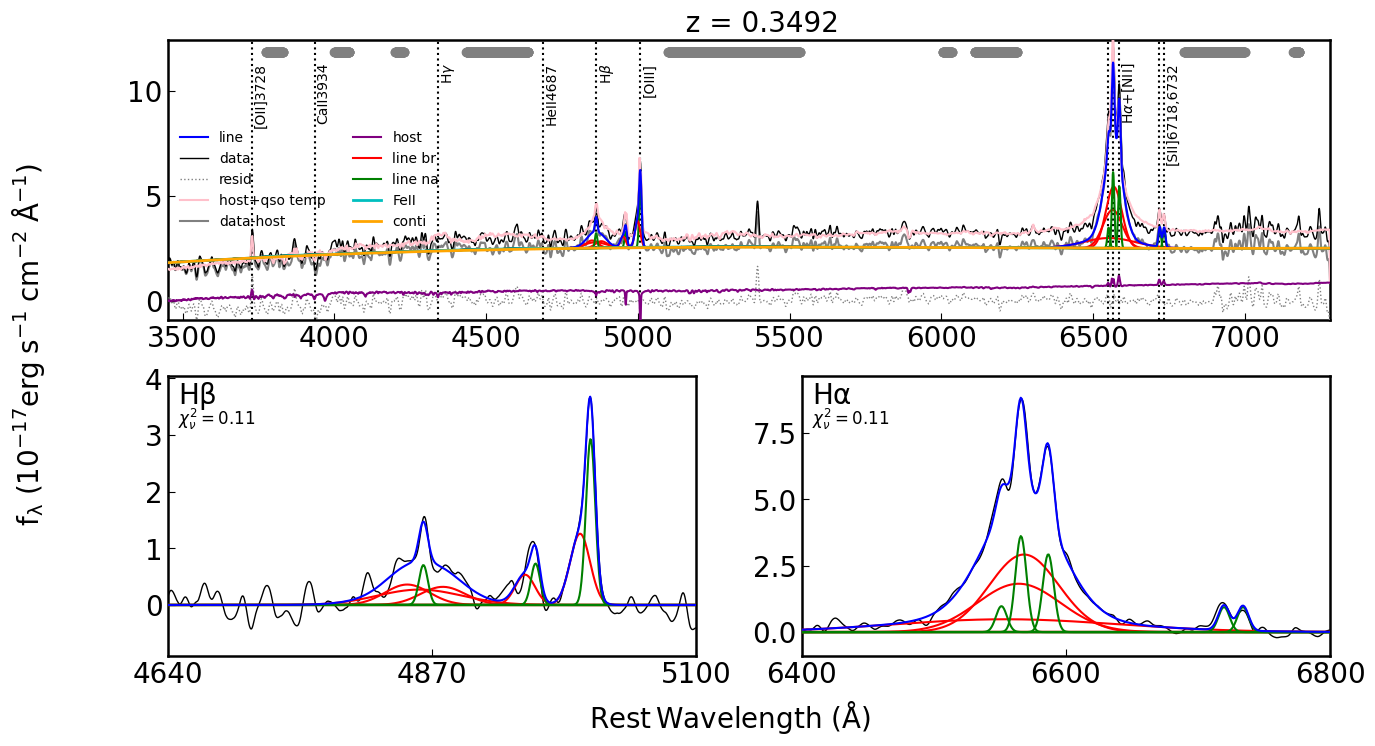

In [243]:
# Prepare data
q_mle = QSOFit(lam_primary_elg, convolve(Added_flux, Gaussian1DKernel(5)), err, redshift, primary_ii_elg, path=path_ex)

# Double check the installation path with the PCA / Fe template files
# print('install path:', q_mle.install_path)

# Change it if you installed them somewhere else
#q_mle.install_path = '...'

start = timeit.default_timer()
# Do the fitting

q_mle.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=1,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=True,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=True,  # If True, the host galaxy-QSO decomposition will be applied
          host_line_mask=True,
          # If True, the line region of galaxy will be masked when subtracted from original spectra
          BC03=False,  # If True, Bruzual1 & Charlot 2003 host model will be used
          Mi=None,  # i-band absolute magnitude, for further decide PCA model, not necessary
          npca_gal=5,  # The number of galaxy PCA components / galaxy models applied
          npca_qso=10,  # The number of QSO PCA components applied

          # continuum model fit parameters
          Fe_uv_op=True,  # If True, fit continuum with UV and optical FeII template
          poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted
          rej_abs_line=False,
          # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=200,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          param_file_name='qsopar.fits',  # Name of the qso fitting parameter FITS file.
          nburn=20,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=True,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=None,  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=True,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=True,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=False,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')
plt.savefig('PYQSO')

# Closing Thoughts
Brief recap, after querying the elg and the QSO spectrum we first filter out the remaining QSOs <br/>
from the ELG Query and using the filtered sample we then use that sample to create an example lensed ELG. <br/>

While an example of what will be done on a much larger sample size using a qso at a higher redshift in comparison to the elg. <br/>